<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/transfer_learning_vgg16_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History 

from random import randint
import numpy as np

import matplotlib.pyplot as plt

from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.pyplot as pp

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

from tensorflow.keras import datasets, layers, models
from xgboost import XGBClassifier
%matplotlib inline

# Making the dataset:

In [ ]:
import os
from tqdm import tqdm
from skimage.io import imread

# read all the images first
x_train = []
for i in range(1, 4): # changed to 3 classes
    base_dir = f'./cancer_data_hd/stage_{i}_png/'
    files = os.listdir(base_dir)
    for file in tqdm(files):
        img = imread(base_dir+file)
        x_train.append(img)
X_train = np.array(x_train)
X_train.shape

100%|██████████| 250/250 [00:00<00:00, 458.59it/s]


(750, 512, 512)

In [ ]:
NUM = 250
CLASSES = 3 #4
y_train = []
class_label = 0
for i in range(NUM * CLASSES):
    if i > 0 and i %  NUM == 0:
        class_label += 1
    y_train.append(class_label)
Y_train = np.array(y_train)

In [ ]:
# Shuffle training data
shuffler = np.random.permutation(NUM * CLASSES)

X_train = np.array(X_train)

shufled_X_train = X_train[shuffler]
shufled_Y_train = Y_train[shuffler]

2


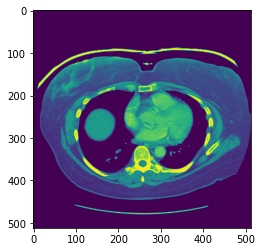

In [ ]:
print(shufled_Y_train[100])
plt.imshow(shufled_X_train[100])

In [ ]:
NUM_TRAIN = int(NUM * CLASSES * 0.85)

X_train = shufled_X_train[ : NUM_TRAIN]
Y_train = shufled_Y_train[ : NUM_TRAIN] 

X_test = shufled_X_train[NUM_TRAIN : ]
Y_test = shufled_Y_train[NUM_TRAIN:] 

In [ ]:
WIDTH = X_train.shape[1]

# Model Work: 

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
# Adding some extra layers before the input to deal with a single channel image
# vgg takes a 3 channel input
img_input = layers.Input(shape=(WIDTH, WIDTH, 1))
img_conc = layers.Concatenate()([img_input, img_input, img_input])

# Load model without classifier/fully connected layers
# the top 3 layers are the fully connected dense layers when we say include_top = False
# it means we don't want them, we only want the Convolutional layers
VGG_model = VGG16(input_tensor=img_conc, weights='imagenet', include_top=False)

In [ ]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False

In [ ]:
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512, 512, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        concatenate[0][0]                
______________________________________________________________________________________________

## Using the model:

In [ ]:
# adding the extra dimension as required by the model
X_wanted_train = X_train.reshape(len(X_train), WIDTH, WIDTH, 1)
X_wanted_test = X_test.reshape(len(X_test), WIDTH, WIDTH, 1)

In [ ]:
# Now, let us get the features from the Convolutional network of the vgg
feature_extractor = VGG_model.predict(X_wanted_train)

features_train = feature_extractor.reshape(feature_extractor.shape[0], -1)

features_train.shape

(637, 131072)

In [ ]:
# Now, let us get the features from the Convolutional network of the vgg
feature_extractor = VGG_model.predict(X_wanted_test)

features_test = feature_extractor.reshape(feature_extractor.shape[0], -1)

# Applying classical models on the features:

## Decision tree:

In [ ]:
results = {}

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['decision_tree'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.9911504424778761

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       0.97      1.00      0.99        34
           2       1.00      0.97      0.98        33

    accuracy                           0.99       113
   macro avg       0.99      0.99      0.99       113
weighted avg       0.99      0.99      0.99       113



[Text(133.92000000000002, 181.2, 'X[128631] <= 1.747\ngini = 0.666\nsamples = 637\nvalue = [204, 216, 217]'),
 Text(66.96000000000001, 108.72, 'gini = 0.0\nsamples = 217\nvalue = [0, 0, 217]'),
 Text(200.88000000000002, 108.72, 'X[120486] <= 15.912\ngini = 0.5\nsamples = 420\nvalue = [204, 216, 0]'),
 Text(133.92000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 204\nvalue = [204, 0, 0]'),
 Text(267.84000000000003, 36.23999999999998, 'gini = 0.0\nsamples = 216\nvalue = [0, 216, 0]')]

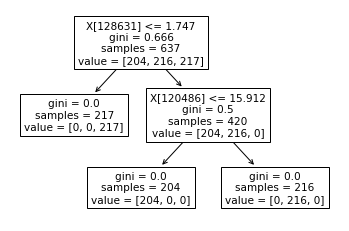

In [ ]:
# plot tree
from sklearn import tree

tree.plot_tree(clf)

## Random Forest:

In [ ]:
# Create Random Forest classifer object
clf = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['random_forest'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        33

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



### Increasing Estimators:

In [ ]:
# Create Random Forest classifer object
clf = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['random_forest_100'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        33

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



## Adaboost Classifier:

In [ ]:
# Create Adaboostclassifier
clf = AdaBoostClassifier(n_estimators=42)

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['adaboost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.9911504424778761

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       0.97      1.00      0.99        34
           2       1.00      0.97      0.98        33

    accuracy                           0.99       113
   macro avg       0.99      0.99      0.99       113
weighted avg       0.99      0.99      0.99       113



## XG Boost Classifier:

In [ ]:
# Create XG boost classifer object
clf = XGBClassifier()

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['xgboost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

/home/ahsanyleg/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:08:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        33

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



## Gaussian Naive Bayes:

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create Gaussian Naive Bayes Classifier
clf = GaussianNB()

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['gaussianNB'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.9911504424778761

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       0.97      1.00      0.99        34
           2       1.00      0.97      0.98        33

    accuracy                           0.99       113
   macro avg       0.99      0.99      0.99       113
weighted avg       0.99      0.99      0.99       113



## Logistic Regression:

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression Classifier
clf = LogisticRegression(solver='liblinear')

# Train Decision Tree Classifer
clf = clf.fit(features_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(features_test)

accuracy = accuracy_score(Y_test, y_pred)
results['logistic'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        33

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



# Plotting the results:

<BarContainer object of 7 artists>

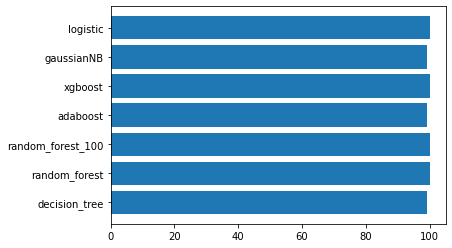

In [ ]:
plt.barh(list(results.keys()), results.values())